In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io
import scipy.fft as fft
import nirsimple as ns
import mne
from scipy.signal import butter, filtfilt

import benchnirs

In [3]:
data = scipy.io.loadmat("Paul_scan1_September112023_1533.nirs")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: Win32NT, CREATED on: Mon, 11 Sep 2023 15:33:37 GMT',
 '__version__': '1.0',
 '__globals__': [],
 'd': array([[37722., 38173., 21970., ..., 35591., 40519., 13684.],
        [34281., 39365., 22480., ..., 37092., 35577., 17520.],
        [33197., 39664., 21464., ..., 36384., 34861., 19841.],
        ...,
        [26567., 30044., 11563., ...,  2881.,  6870.,  6762.],
        [26552., 29947., 11562., ...,  2892.,  6844.,  6750.],
        [26457., 29648., 11507., ...,  2893.,  6801.,  6715.]]),
 'aux': array([[ 66.,  32.,  55., ...,  27., 105.,  92.],
        [ 66.,  32.,  55., ...,  27., 151.,  52.],
        [ 66.,  32.,  55., ...,  27.,   5., 212.],
        ...,
        [ 81.,  32.,  57., ...,  26., 253., 216.],
        [ 81.,  32.,  57., ...,  26., 204., 165.],
        [ 81.,  32.,  57., ...,  26., 172., 165.]]),
 't': array([[0.000e+00],
        [1.000e-01],
        [2.000e-01],
        ...,
        [4.838e+02],
        [4.839e+02],
       

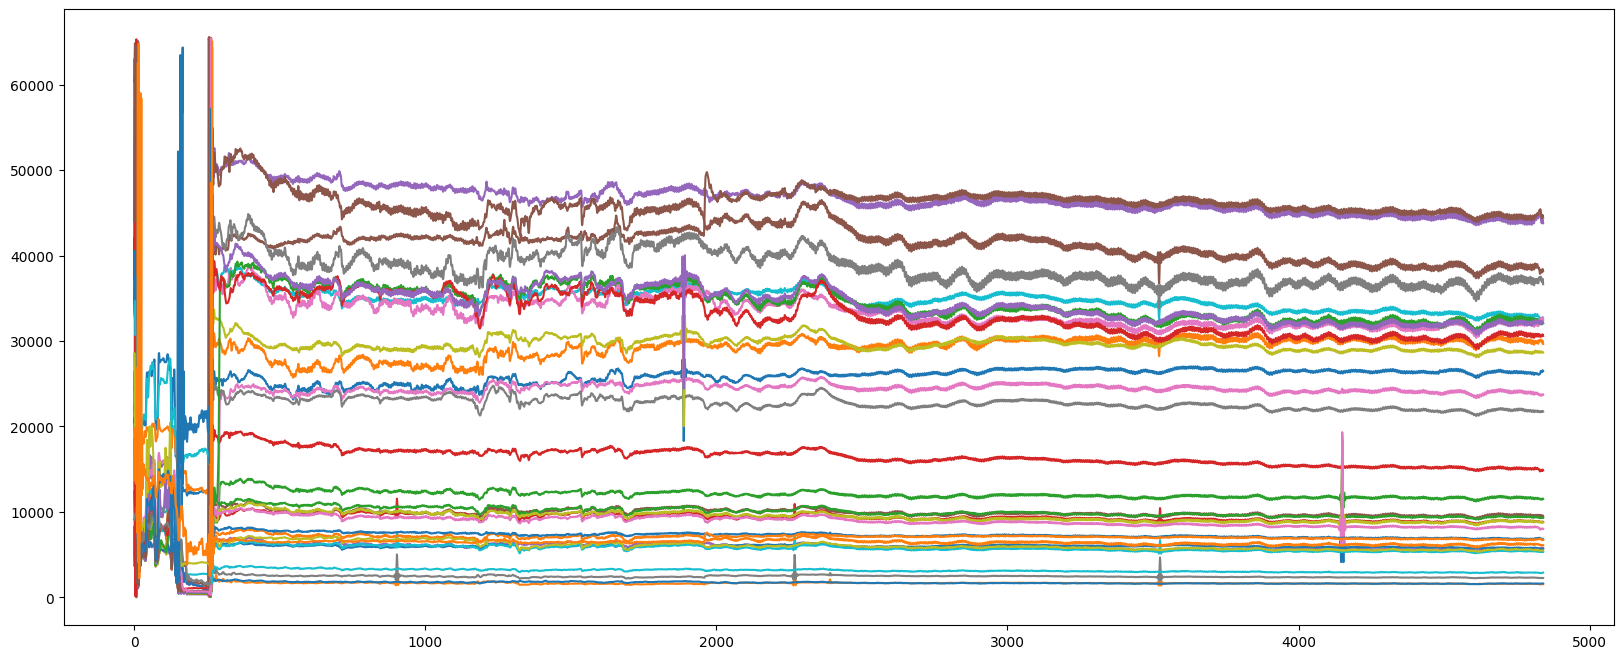

In [4]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(data["d"][:,:])), data["d"][:, :])

In [48]:
 #*10 to convert 10hz sample times like 132.7 to time indices like 1327
event_times = [i*10 for i in data["StimDesign"][0][0][1][0]]
print("event times", event_times)

#Record i+1's event start time as event i's sto; time
start_stop_times = list(zip(event_times[:-1], event_times[1:]))

event_data = [data["d"][int(start):int(stop)] for start, stop in start_stop_times]
print("event data time, channels", len(event_data), len(event_data[0][0]))
print("event lengths", [len(dat) for dat in event_data])

#Alternating binary labels for each consecutive event (0, 1, 0, 1, ...).
event_labels = np.resize([0,1], len(event_data))

print("splitting")
#Split the event data into 5 second intervals (since signal is 10hz, that's 10*5=50 time steps
split_event_data = []
split_event_labels = []
n = 50
for event, label in zip(event_data, event_labels):
    num_parts = len(event) // n
    split_event_data.extend(np.split(event[:num_parts * n], num_parts))
    split_event_labels.extend([label] * num_parts)
split_event_data = np.stack(split_event_data)
split_event_labels = np.stack(split_event_labels)
print("event data", split_event_data.shape)
print("event lengths", [len(dat) for dat in split_event_data])
print("event labels", len(split_event_labels), split_event_labels)

event times [2352.0, 2754.0, 3013.0, 3496.0, 3833.0, 4443.0]
event data time, channels 5 32
event lengths [402, 259, 483, 337, 610]
splitting
event data (40, 50, 32)
event lengths [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
event labels 40 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0]


In [6]:
get_benchnirs_format = lambda arr: np.reshape(arr, (arr.shape[0], arr.shape[2], arr.shape[1]))

In [36]:
benchnirs_event_data = get_benchnirs_format(split_event_data)
print("benchnirs event data shape", benchnirs_event_data.shape)
benchnirs_event_labels = split_event_labels

benchnirs event data shape (40, 32, 50)


In [35]:
print("Class proportions", np.bincount(benchnirs_event_labels)/len(benchnirs_event_labels))

Class proportions [0.725 0.275]


(array([436., 609., 611., 594., 590., 628., 558., 589., 570., 625., 598.,
        604., 574., 558., 581., 649., 612., 596., 622., 621., 601., 571.,
        593., 586., 607., 593., 610., 589., 588., 437.]),
 array([-114.81765274, -106.33785897,  -97.8580652 ,  -89.37827144,
         -80.89847767,  -72.4186839 ,  -63.93889013,  -55.45909636,
         -46.97930259,  -38.49950882,  -30.01971505,  -21.53992128,
         -13.06012751,   -4.58033375,    3.89946002,   12.37925379,
          20.85904756,   29.33884133,   37.8186351 ,   46.29842887,
          54.77822264,   63.25801641,   71.73781018,   80.21760394,
          88.69739771,   97.17719148,  105.65698525,  114.13677902,
         122.61657279,  131.09636656,  139.57616033]),
 <BarContainer object of 30 artists>)

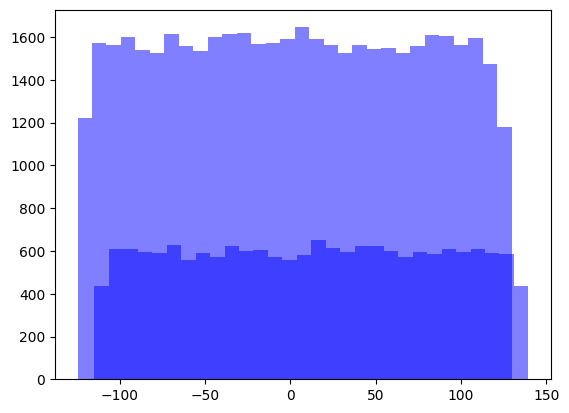

In [60]:
synthetic_events = []
for event_label in split_event_labels:
    if event_label == 0:
        synthetic_event = np.random.uniform(0,5, split_event_data.shape[1:])
    else: 
        synthetic_event = np.random.uniform(10,15, split_event_data.shape[1:])
    synthetic_events.append(synthetic_event)
synthetic_event_data = np.stack(synthetic_events)

noise = (np.random.random(synthetic_event_data.shape) - np.array(.5)) * 250
synthetic_event_data += noise

benchnirs_synthetic_event_data = get_benchnirs_format(synthetic_event_data)

plt.hist(benchnirs_synthetic_event_data[benchnirs_event_labels == 0].flatten(), bins=30, alpha=0.5, label='class 0', color='blue')
plt.hist(benchnirs_synthetic_event_data[benchnirs_event_labels == 1].flatten(), bins=30, alpha=0.5, label='class 1', color='blue')

In [61]:
n_maj = round(40 * .5)
n_min = 40 - n_maj
#benchnirs_event_labels = np.array([0]*n_maj + [1]*n_min)
print(benchnirs_event_labels)
benchnirs.learn.machine_learn(
    nirs=benchnirs_synthetic_event_data,
    labels=benchnirs_event_labels,
    groups=None,
    model="ann",
    features=["mean"], 
    normalize=True,
    random_state=None,
    output_folder="outputs"
)

[0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0]
Machine learning: ann
	FOLD #1
	FOLD #2
	FOLD #3
	FOLD #4
	FOLD #5


([0.875, 1.0, 1.0, 1.0, 0.875],
 [None, None, None, None, None],
 [(0.875, 0.875, 0.875),
  (1.0, 1.0, 1.0),
  (1.0, 1.0, 1.0),
  (1.0, 1.0, 1.0),
  (0.875, 0.875, 0.875)])